<a href="https://colab.research.google.com/github/NavaSergio/TT/blob/main/Para%20python/Sesion%201/Sesion1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CONSTRUCCION DE INDICADORES REGIONALES

## Sesión 1.2
COEFICIENTE DE LOCALIZACION

Primero cargamos las bibliotecas necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


COEFICIENTE DE LOCALIZACIÓN
Creamos la función _locq2_ para calcular el coeficiente de localización

In [2]:

# Definir función locq (Cociente de Localización)
def locq(e_ij, industry_id, region_id):
    industry_totals = e_ij.groupby(industry_id, observed=False).sum()  # Agrega observed=False
    region_totals = e_ij.groupby(region_id, observed=False).sum()      # Agrega observed=False
    total_sum = e_ij.sum()
    return (e_ij / industry_totals.loc[industry_id].values) / (
        region_totals.loc[region_id].values / total_sum
    )

def locq2(e_ij, industry_id, region_id):
    """
    Calcula el Coeficiente de Localización Hoover-Balassa para una matriz de datos.

    Parámetros:
    - e_ij: Serie con los valores de empleo (o población ocupada).
    - industry_id: Identificador de la industria.
    - region_id: Identificador de la región.

    Retorna:
    - DataFrame con el LQ calculado para cada industria y región.
    """
    # Convertir a DataFrame para manipulación más sencilla
    data = pd.DataFrame({
        "e_ij": e_ij,
        "industry_id": industry_id,
        "region_id": region_id
    })

    # Calcular totales con observed=False
    data["industry_total"] = data.groupby("industry_id", observed=False)["e_ij"].transform("sum")  # ∑j Eij
    data["region_total"] = data.groupby("region_id", observed=False)["e_ij"].transform("sum")      # ∑i Eij
    total_sum = data["e_ij"].sum()                                                                # ∑ij Eij

    # Calcular el cociente de localización
    data["LQ"] = (data["e_ij"] / data["industry_total"]) / (data["region_total"] / total_sum)

    # Reorganizar en forma de matriz (opcional, útil para mapas de calor)
    lq_matrix = data.pivot(index="industry_id", columns="region_id", values="LQ")

    return lq_matrix



def hoover(values, ref):
    """
    Calcula el índice de Hoover para una columna.

    Parámetros:
    - values: Array o Serie con los valores a evaluar.
    - ref: Serie o array con los valores de referencia (total sectorial).

    Retorna:
    - Índice de Hoover.
    """
    abs_diff = np.abs(values - ref / len(values))  # Diferencias absolutas
    return np.sum(abs_diff) / (2 * np.sum(ref))    # Índice de Hoover


Selecciona Directorio de trabajo. No es necesario si los datos están en la misma ruta que el portafolio. En el caso de colab recuerde que debe subir el archivo de datos. También llenaremos los valores faltantes con 0's y cambiaremos a categorías las variables Año y Sector.

In [3]:

# Cargar archivo Excel
matriz = pd.read_excel("Modif base total secre.xlsx")

# Convertir valores vacíos a 0
matriz.fillna(0, inplace=True)

# Renombrar columnas
matriz.columns = [
    "Año", "No_sector", "Sector", "Aguascalientes", "Baja California",
    "Baja California Sur", "Campeche", "Coahuila", "Colima", "Chiapas",
    "Chihuahua", "CDMX", "Durango", "Guanajuato", "Guerrero", "Hidalgo",
    "Jalisco", "Mexico", "Michoacan", "Morelos", "Nayarit", "Nuevo Leon",
    "Oaxaca", "Puebla", "Queretaro", "Quintana Roo", "San Luis Potosi",
    "Sinaloa", "Sonora", "Tabasco", "Tamaulipas", "Tlaxcala", "Veracruz",
    "Yucatan", "Zacatecas", "Total_Sectorial"
]

# Convertir columnas categóricas
matriz['Sector'] = matriz['Sector'].astype('category')
matriz['No_sector'] = matriz['No_sector'].astype(str).str.zfill(2)


In [4]:

# Quitar la columna "Total_Sectorial" y filtrar las filas antes del melt
matriz_filtrada = matriz.loc[matriz["Sector"] != "Total Región"].drop(columns=["Total_Sectorial"], errors="ignore")

# Transformar a formato largo
matriz_long = matriz_filtrada.melt(
    id_vars=["Año", "No_sector", "Sector"],  # Identificadores que deben mantenerse
    var_name="ENTIDAD",
    value_name="Pers_ocup"
).reset_index(drop=True)  # Restablecer índice


matriz_long["ENTIDAD"] = matriz_long["ENTIDAD"].astype('category')

# Filtrar por año
matpob_2018 = matriz_long[matriz_long["Año"] == 2018].copy()
matpob_2013 = matriz_long[matriz_long["Año"] == 2013].copy()


In [5]:

# Calcular coeficiente de localización para 2018 y 2013
local2_2018 = locq2(matpob_2018["Pers_ocup"], matpob_2018["Sector"], matpob_2018["ENTIDAD"])
local2_2013 = locq2(matpob_2013["Pers_ocup"], matpob_2013["Sector"], matpob_2013["ENTIDAD"])
print(local2_2013)
print(local2_2018)

region_id                                           Aguascalientes  \
industry_id                                                          
11. Agricultura, ganadería, aprovechamiento for...        0.045392   
21. Minería                                               0.251189   
22. Electricidad, agua y suministro de gas por ...        0.512936   
23. Construcción                                          1.465961   
31-33. Industrias manufacturera                           1.381367   
43. Comercio al por mayor                                 1.043160   
46. Comercio al por menor                                 0.912708   
48-49. Transportes, correos y almacenamiento              0.754445   
51. Información en medios masivos                         0.629686   
52.Servicios financieros y de seguros                     0.235920   
53. Servicios inmobiliarios y de alquiler de bi...        1.057836   
54. Servicios profesionales, científicos y técn...        1.157251   
55. Dirección de cor

In [6]:

local2_2013_copia = local2_2013.copy()
local2_2018_copia = local2_2018.copy()

# Combinar resultados
# Agregar la columna "Año" a cada DataFrame
local2_2018_copia["Año"] = 2018
local2_2013_copia["Año"] = 2013


local2_2018_copia = local2_2018_copia.reset_index()
local2_2013_copia = local2_2013_copia.reset_index()

# Combinar las filas de ambos DataFrames
localhoover_bal2 = pd.concat([local2_2018_copia, local2_2013_copia], axis=0, ignore_index=True)


local2_2018 = pd.DataFrame(local2_2018)
local2_2013 = pd.DataFrame(local2_2013)


In [7]:

# Guardar en archivos
localhoover_bal2.to_csv("Cociente_de_Localizacion_facil.csv", index=False)
localhoover_bal2.to_excel("Cociente_de_localizacion.xlsx", index=False)


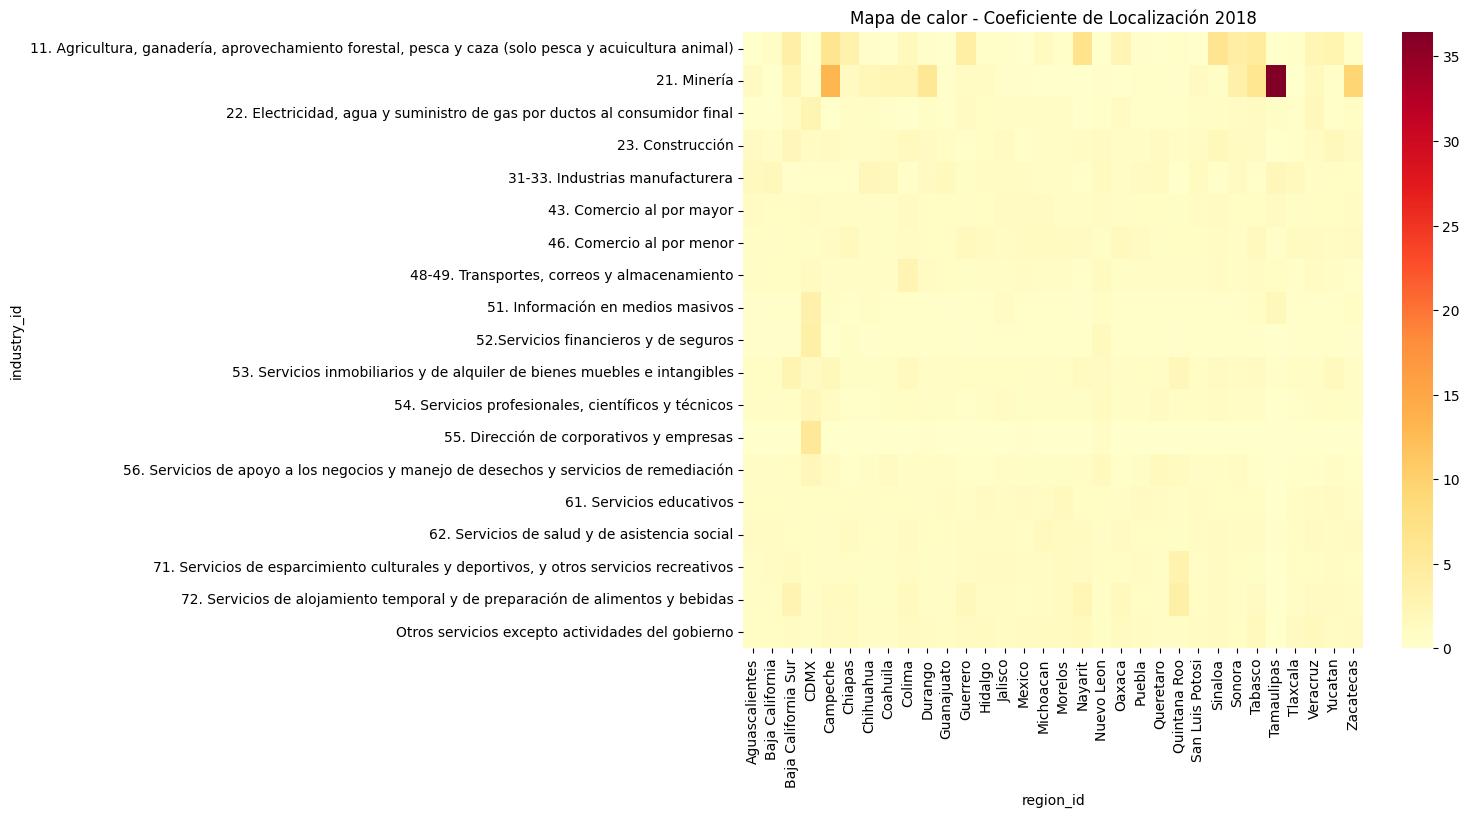

In [8]:

# Graficar mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(local2_2018, annot=False, fmt=".2f", cmap="YlOrRd", cbar=True)
plt.title("Mapa de calor - Coeficiente de Localización 2018")
plt.show()


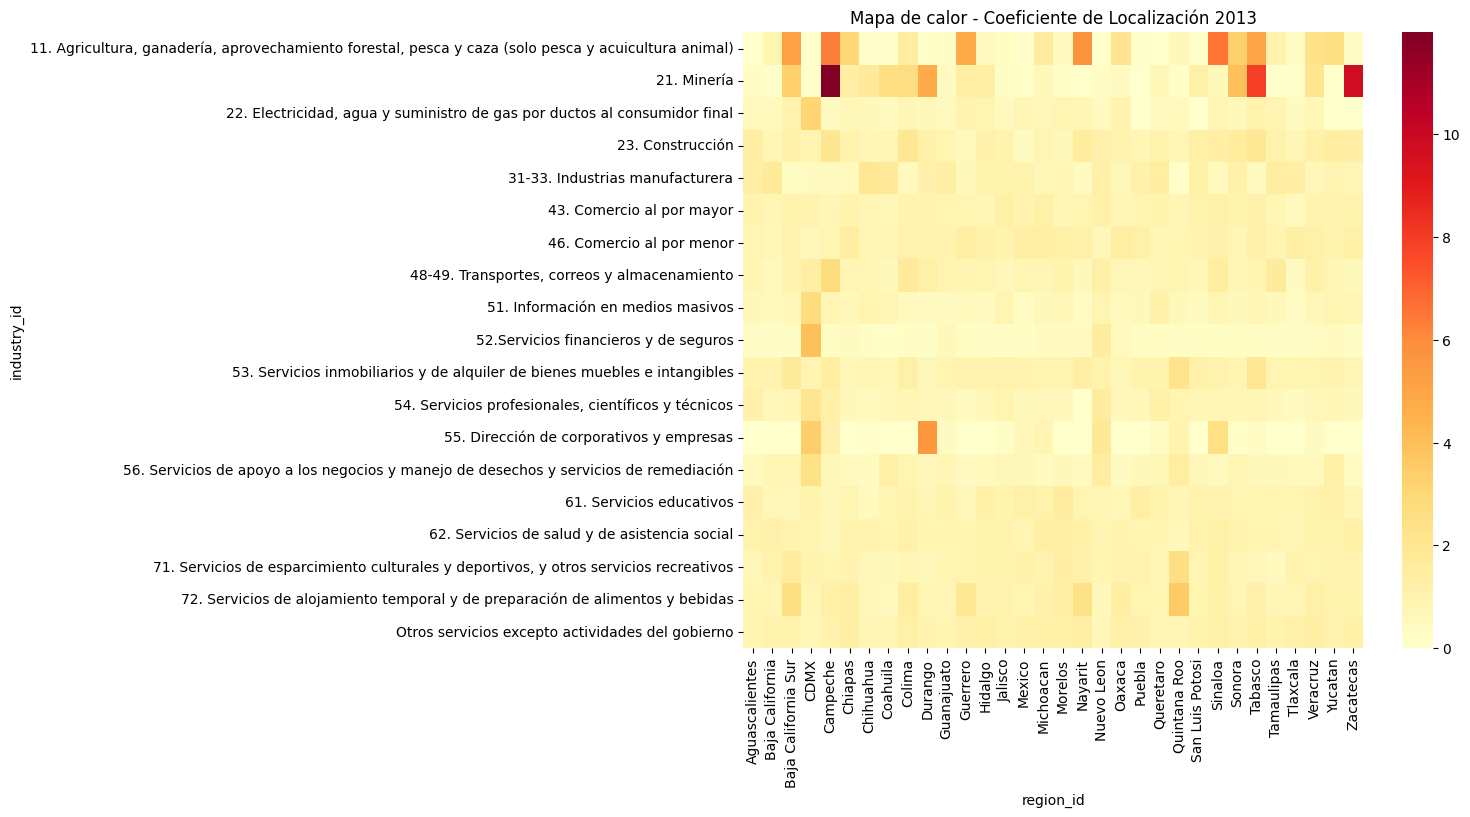

In [9]:

# Graficar mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(local2_2013, annot=False, fmt=".2f", cmap="YlOrRd", cbar=True)
plt.title("Mapa de calor - Coeficiente de Localización 2013")
plt.show()


In [10]:

# Cargar archivo Excel
matriz = pd.read_excel("Modif base total secre.xlsx")


# Renombrar columnas
matriz.columns = [
    "Año", "No_sector", "Sector", "Aguascalientes", "Baja California",
    "Baja California Sur", "Campeche", "Coahuila", "Colima", "Chiapas",
    "Chihuahua", "CDMX", "Durango", "Guanajuato", "Guerrero", "Hidalgo",
    "Jalisco", "Mexico", "Michoacan", "Morelos", "Nayarit", "Nuevo Leon",
    "Oaxaca", "Puebla", "Queretaro", "Quintana Roo", "San Luis Potosi",
    "Sinaloa", "Sonora", "Tabasco", "Tamaulipas", "Tlaxcala", "Veracruz",
    "Yucatan", "Zacatecas", "Total_Sectorial"
]

# Convertir columnas categóricas
matriz['Sector'] = matriz['Sector'].astype('category')
matriz['No_sector'] = matriz['No_sector'].astype(str).str.zfill(2)


In [11]:

# Calcular índice de Hoover para población ocupada
matriz_pob2018 = matriz.iloc[1:20, 3:36]
matriz_pob2013 = matriz.iloc[21:40, 3:36]


In [15]:
# Aplicar la función Hoover para 2018
hoover_2018 = matriz_pob2018.iloc[:, :32].apply(
    lambda col: hoover(col, matriz_pob2018["Total_Sectorial"]), axis=0
).round(4)

# Aplicar la función Hoover para 2013
hoover_2013 = matriz_pob2013.iloc[:, :32].apply(
    lambda col: hoover(col, matriz_pob2013["Total_Sectorial"]), axis=0
).round(4)

#hoover_2018 = matriz_pob2018.apply(hoover, axis=0, ref=matriz_pob2018["Total_Sectorial"].sum())
#hoover_2013 = matriz_pob2013.apply(hoover, axis=0, ref=matriz_pob2013["Total_Sectorial"].sum())
print(hoover_2013)
print(hoover_2018)

Aguascalientes         0.0200
Baja California        0.0107
Baja California Sur    0.0226
Campeche               0.0224
Coahuila               0.0111
Colima                 0.0231
Chiapas                0.0158
Chihuahua              0.0128
CDMX                   0.0580
Durango                0.0202
Guanajuato             0.0052
Guerrero               0.0174
Hidalgo                0.0181
Jalisco                0.0115
Mexico                 0.0228
Michoacan              0.0121
Morelos                0.0194
Nayarit                0.0214
Nuevo Leon             0.0108
Oaxaca                 0.0157
Puebla                 0.0057
Queretaro              0.0157
Quintana Roo           0.0186
San Luis Potosi        0.0163
Sinaloa                0.0159
Sonora                 0.0128
Tabasco                0.0201
Tamaulipas             0.0107
Tlaxcala               0.0221
Veracruz               0.0067
Yucatan                0.0161
Zacatecas              0.0220
dtype: float64
Aguascalientes         0.

In [16]:

# Guardar resultados
hoover_df = pd.DataFrame({"Hoover_2018": hoover_2018, "Hoover_2013": hoover_2013})
hoover_df.to_csv("Coeficiente_Hoover_Pob_Ocupada.csv", index=False)


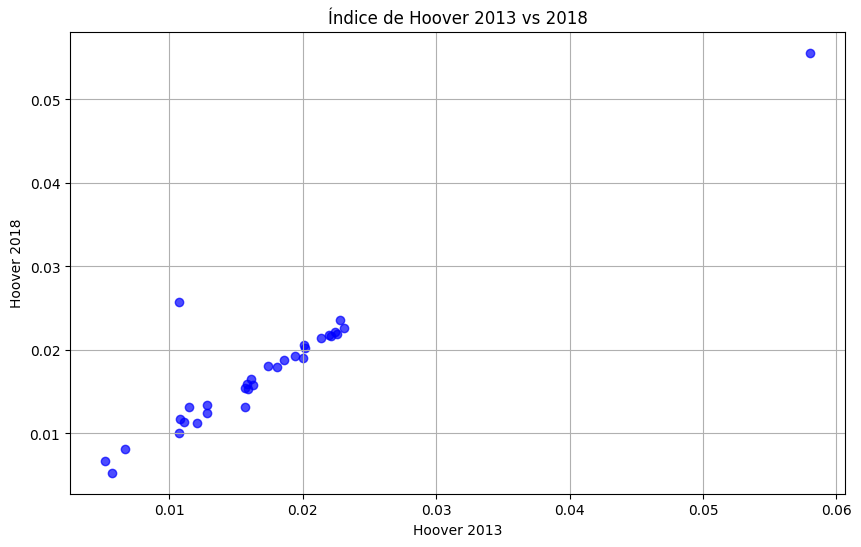

In [17]:

# Graficar comparación Hoover 2013 vs 2018
plt.figure(figsize=(10, 6))
plt.scatter(hoover_df["Hoover_2013"], hoover_df["Hoover_2018"], color="blue", alpha=0.7)
plt.title("Índice de Hoover 2013 vs 2018")
plt.xlabel("Hoover 2013")
plt.ylabel("Hoover 2018")
plt.grid(True)
plt.show()
